# Random Forest

In [26]:
from pandas import DataFrame
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler


def drop_empty_items(data_frame: DataFrame) -> DataFrame:
    data_frame = data_frame.drop(['Insulin'], axis=1)
    return data_frame[(data_frame['Glucose'] != 0) & (data_frame['BloodPressure'] != 0) & (data_frame['BMI'] != 0)]


def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test


def print_score(y_test, y_pred) -> None:
    # Calculate other evaluation metrics for test set
    print(f"SIMPLE RANDOM FOREST")
    print("===========================================================================")
    print("\nClassification Report:\n",
          classification_report(y_test, y_pred, target_names=['non-diabetic', 'diabetic']))
    print("Decision Tree Model Evaluation:")

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Accuracy: ", accuracy)
    print(f"Precision (Weighted): {precision:.6f}")
    print(f"Recall (Weighted): {recall:.6f}")
    print(f"F1-Score (Weighted): {f1:.6f}")

    print("Class distribution before SMOTE:", y_train.value_counts().to_dict())
    print("Class distribution after SMOTE:", pd.Series(y_train_smote).value_counts().to_dict())

    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC-AUC: {roc_auc:.6f}")

    # Print confusion matrix with class labels
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_names = ['non-diabetic', 'diabetic']
    print("\nConfusion Matrix with Class Labels:")
    print(pd.DataFrame(conf_matrix, index=class_names, columns=class_names))

    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    print("Specificity: ", specificity)
    sensitivity = tp / (tp + fn)
    print("Sensitivity: ", sensitivity)

In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

features = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'SkinThickness', 'DiabetesPedigreeFunction', 'Age']

df = pd.read_csv('data/diabetes.csv')
df = drop_empty_items(df)

# Feature/Output Separation
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Features
X_train, X_test = scale_features(X_train, X_test)

# SMOTE - Artificial Data Creation
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize Random Forest and Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit Grid Search on SMOTE-balanced training data
grid_search.fit(X_train_smote, y_train_smote)

# Print best parameters and score
print("\nBest Hyperparameters:")
print(grid_search.best_params_)
print(f"Best Cross-Validation F1-Weighted Score: {grid_search.best_score_:.6f}")

# Train best model on full SMOTE training data
best_rf = grid_search.best_estimator_
best_rf.fit(X_train_smote, y_train_smote)

# Evaluate best model on test set
y_pred = best_rf.predict(X_test)
print_score(y_test, y_pred)

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best Hyperparameters:
{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation F1-Weighted Score: 0.809426
SIMPLE DECISION TREE

Classification Report:
               precision    recall  f1-score   support

non-diabetic       0.89      0.77      0.83       102
    diabetic       0.59      0.77      0.67        43

    accuracy                           0.77       145
   macro avg       0.74      0.77      0.75       145
weighted avg       0.80      0.77      0.78       145

Decision Tree Model Evaluation:
Accuracy:  0.7724137931034483
Precision (Weighted): 0.799163
Recall (Weighted): 0.772414
F1-Score (Weighted): 0.779611
Class distribution before SMOTE: {0: 373, 1: 206}
Class distribution after SMOTE: {0: 373, 1: 373}
ROC-AUC: 0.770976

Confusion Matrix with Class Labels:
              non-diabetic  diabetic
non-diabetic            79        23
diabeti

# Visualizations

<Figure size 800x600 with 0 Axes>

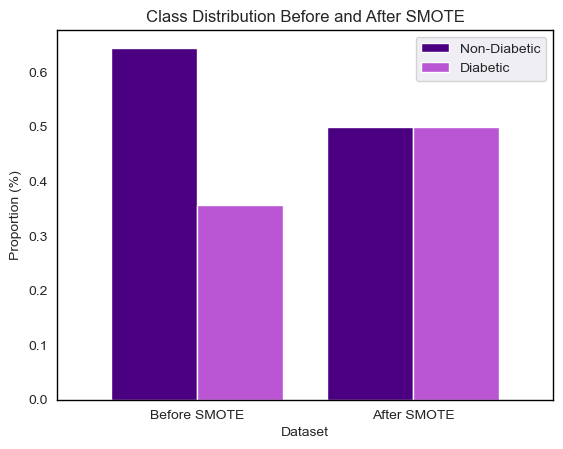

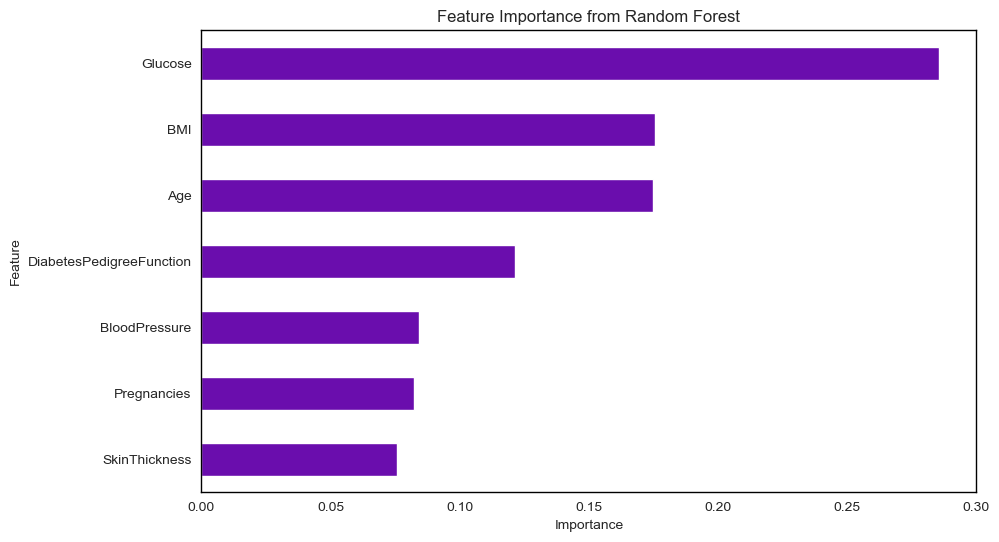

ValueError: Must pass 2-d input. shape=()

<Figure size 800x600 with 0 Axes>

In [28]:
from matplotlib import pyplot as plt
import seaborn as sns

# Visualization 1: Class Distribution Before and After SMOTE
plt.figure(figsize=(8, 6))
class_dist = pd.DataFrame({
    'Before SMOTE': y_train.value_counts(normalize=True),
    'After SMOTE': pd.Series(y_train_smote).value_counts(normalize=True)
}).T
class_dist.columns = ['Non-Diabetic', 'Diabetic']
class_dist.plot(kind='bar', color=['#4B0082', '#BA55D3'], width=0.8) #['#4B0082', '#6A0DAD', '#8A2BE2', '#9932CC', '#BA55D3']
plt.title('Class Distribution Before and After SMOTE')
plt.xlabel('Dataset')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_facecolor('none')
plt.gcf().set_facecolor('none')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)
plt.show()
plt.close()

# Visualization 2: Feature Importance from Random Forest
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(best_rf.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=True).plot(kind='barh', color='#6A0DAD') #'#4B0082', '#6A0DAD'
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
ax = plt.gca()
ax.set_facecolor('none')
plt.gcf().set_facecolor('none')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)
plt.show()
plt.close()

# Visualization 3: Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax = plt.gca()
ax.set_facecolor('none')
plt.gcf().set_facecolor('none')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)
plt.show()
plt.close()

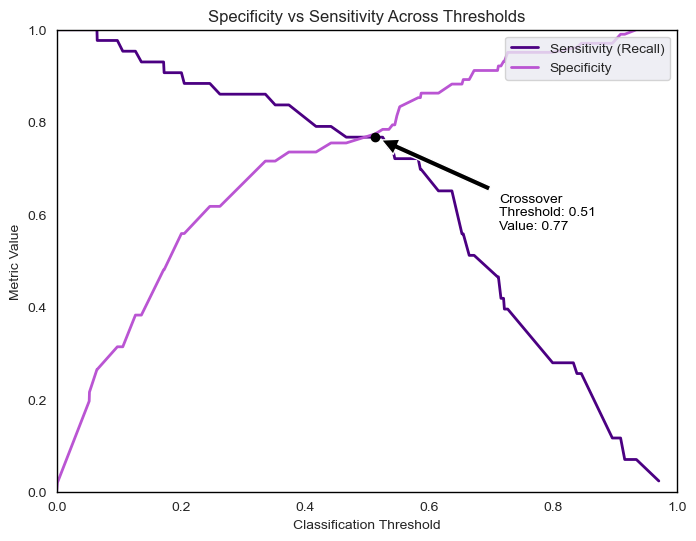

In [29]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve

# Assuming best_rf, X_test, and y_test are available from your Random Forest model

# Get predicted probabilities for the positive class (Diabetic)
y_prob = best_rf.predict_proba(X_test)[:, 1]

# Compute sensitivity (TPR) and specificity (TNR) across thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
specificity = 1 - fpr  # Specificity = 1 - False Positive Rate
sensitivity = tpr  # Sensitivity = True Positive Rate

# Find the crossover point (where sensitivity ≈ specificity)
diff = np.abs(sensitivity - specificity)
crossover_idx = np.argmin(diff)
crossover_threshold = thresholds[crossover_idx]
crossover_value = sensitivity[crossover_idx]  # Since sensitivity ≈ specificity at crossover

# Visualization 5: Specificity vs Sensitivity Line Graph with Crossover Label
plt.figure(figsize=(8, 6))
plt.plot(thresholds, sensitivity, label='Sensitivity (Recall)', color='#4B0082', linewidth=2)
plt.plot(thresholds, specificity, label='Specificity', color='#BA55D3', linewidth=2)

# Add label at the crossover point
plt.plot(crossover_threshold, crossover_value, 'ko')  # Mark the crossover with a black dot
plt.annotate(
    f'Crossover\nThreshold: {crossover_threshold:.2f}\nValue: {crossover_value:.2f}',
    xy=(crossover_threshold, crossover_value),
    xytext=(crossover_threshold + 0.2, crossover_value - 0.2),
    arrowprops=dict(facecolor='black', shrink=0.05),
    fontsize=10,
    color='black'
)

plt.title('Specificity vs Sensitivity Across Thresholds')
plt.xlabel('Classification Threshold')
plt.ylabel('Metric Value')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_facecolor('none')
plt.gcf().set_facecolor('none')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)
plt.show()
plt.close()